$$\textbf{Machine Learning. Tarea 1: Métodos de descenso para Funciones de base radial}$$
$$\textit{Y. Sarahi García Gozález}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2

<font size=4 color='mediumslateblue'>  

$\textit{Librerías}$

In [2]:
print("Tarea realizada en MacOs. \nLas versiones de las librerías y de python utilizadas fueron:\n")
from platform import python_version
print("Python version:", python_version())
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)


Tarea realizada en MacOs. 
Las versiones de las librerías y de python utilizadas fueron:

Python version: 3.11.5
NumPy version: 1.23.5
Pandas version: 2.1.4


<font size=4 color='mediumslateblue'>  

$\textit{Prepocesamiento de la imagen}$

In [222]:
#leemos la imagen
Lena = Image.open("Lena_image.png")
#obtenemos la matriz
lena_matrix = np.array(Lena)
#normalizamos
lena_matrix=(lena_matrix / np.max(lena_matrix))

Dimensiones de la imagen:  (256, 256)


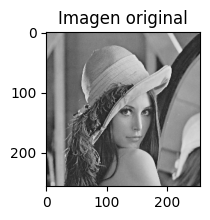

In [289]:
#Dimensiones de la imagen
print("Dimensiones de la imagen: " ,lena_matrix.shape) # (256, 256)
#mostramos la imagen
plt.figure(figsize=(6, 2))
plt.imshow(Lena,cmap='gray')
plt.title('Imagen original')
plt.show()

In [290]:
#matriz ya normalizada
lena_matrix

array([[0.18333333, 0.18333333, 0.05833333, ..., 0.40833333, 0.40833333,
        0.01666667],
       [0.18333333, 0.18333333, 0.05833333, ..., 0.43333333, 0.40833333,
        0.01666667],
       [0.24166667, 0.        , 0.00833333, ..., 0.10833333, 0.125     ,
        0.575     ],
       ...,
       [0.25      , 0.15      , 0.21666667, ..., 0.45      , 0.38333333,
        0.44166667],
       [0.25833333, 0.15      , 0.15      , ..., 0.26666667, 0.23333333,
        0.15833333],
       [0.20833333, 0.14166667, 0.15      , ..., 0.23333333, 0.23333333,
        0.33333333]])

Redimensionamos a 128 para reducir el numero de parametros

In [283]:
Lena_redim = cv2.resize(lena_matrix, (128,128))

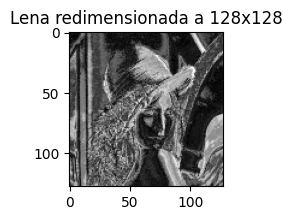

In [291]:
#Imprimimos con las nuevas dimensiones y con la normalización aplicada
plt.figure(figsize=(6, 2))
plt.imshow(Lena_redim, cmap='gray')
plt.title('Lena redimensionada a 128x128')
plt.show()

In [295]:
#obtenemos la matriz de la imagen redimensionada
lena_matrix = np.array(Lena_redim)
#convertimos a vector
lena_vector = lena_matrix.flatten()

In [296]:
lena_vector.shape #256*256=65,536

(16384,)

In [297]:
lena_vector

array([0.18333333, 0.12083333, 0.09583333, ..., 0.57916667, 0.35208333,
       0.23958333])

Buscamos aproximar la imagen anterior pensandola como una función $f$ que a cada pixel $x=(x_1,x_2)$ le asigna un valor entre 0 y 1. Dicha aproximación se hará mediante una suma de funciones:

$$f(x) = \sum_{j=1}^J \alpha_j \phi(x; \theta_j) + \eta(x) $$ 

con $\eta(x)$ un residual

In [201]:
# Definición de laa funciones base y us gradientes
def base_gaussiana(x, theta, kappa):
    r2 = (x - theta)**2
    return np.exp(-kappa * r2)

def grad_gaussiana (x, theta, kappa):
    r2 = (x - theta)**2
    return kappa*(2*x - 2*theta)*(np.exp(-kappa*r2))

def base_multiquadrica(x, theta, kappa):
    r2 = (x - theta)**2
    return np.sqrt(r2+kappa)

def grad_multiquadrica(x, theta, kappa):
    r2 = (x - theta)**2
    resultado = -(x - theta) / np.sqrt(kappa + r2)
    return resultado


<font size=4 color='mediumslateblue'>  

$\textit{Parte 1}$

In [236]:
def genera_phi(theta,f_base,imagen_vector,kappa):
    '''

    '''
    N2=len(imagen_vector)
    J=len(theta)
    phi=np.zeros((N2,J))

    for i in range(N2):
        for j in range(J):
            phi[i][j]=f_base(i*(1/65536),theta[j],kappa)

    return phi

In [237]:
J=200
theta = np.random.uniform(low=0, high=1, size = J)
kappa=0
Phi=genera_phi(theta,base_multiquadrica,lena_vector,kappa)



In [238]:
Phi.shape

(65536, 200)

In [239]:
# Calcula la pseudoinversa de Moore-Penrose de phi
phi_pseudoinv = np.linalg.pinv(Phi)
# Resuelve el sistema utilizando la pseudoinversa de Moore-Penrose
alpha = np.dot(phi_pseudoinv, lena_vector)
#alpha, residuals, _, _ = np.linalg.lstsq(Phi, lena_vector, rcond=None)

In [258]:
alpha = phi_pseudoinv.dot(lena_vector)

In [259]:
Phi

array([[0.97795363, 0.41765897, 0.50060184, ..., 0.66608928, 0.16130974,
        0.69381047],
       [0.97793837, 0.41764371, 0.50058658, ..., 0.66607403, 0.16129448,
        0.69379521],
       [0.97792311, 0.41762845, 0.50057132, ..., 0.66605877, 0.16127922,
        0.69377995],
       ...,
       [0.02200059, 0.58229526, 0.49935239, ..., 0.33386494, 0.83864448,
        0.30614375],
       [0.02201585, 0.58231051, 0.49936765, ..., 0.3338802 , 0.83865974,
        0.30615901],
       [0.02203111, 0.58232577, 0.4993829 , ..., 0.33389546, 0.838675  ,
        0.30617427]])

In [260]:
alpha

array([ 1.38814117e+02,  2.75657908e+01,  2.53049209e+00, -4.07730342e-01,
        5.62019905e-01,  3.47480920e+01, -9.78613235e+00,  5.82360104e+02,
        6.58085121e+00, -3.09979633e-01,  1.76732837e+02,  6.00503943e+00,
       -1.81339415e+03, -2.39224290e+01, -8.91904607e+00, -1.53815902e+01,
        2.97266340e+01, -6.22849384e+02, -1.83914571e+00,  1.09662546e+04,
        8.18554930e+00,  1.67638071e+00,  4.68415883e+00, -2.42689660e+00,
        1.80413574e+01,  2.41724914e+00, -3.79677042e+01,  2.16553355e+02,
       -1.03589118e+04, -2.82600064e+00, -2.08268988e+01, -5.00865777e-01,
        8.19814249e+01, -3.30385861e+00,  1.94046623e+03,  2.17465873e+01,
        2.12699512e+02, -2.43928966e+01, -4.67335952e-01, -4.05945548e+01,
        3.77868031e-01, -1.61055671e+02, -6.01761773e+00, -5.55829734e+00,
        1.91673087e+01,  4.92996858e+00, -2.06120233e+02, -4.74126548e+02,
       -8.49078024e+01,  2.15849769e+00, -4.21400354e+00, -2.86626064e+01,
        2.45950791e+01, -

In [261]:
aproximacion=Phi@alpha

In [262]:
aproximacion

array([0.15978065, 0.15977354, 0.15976643, ..., 0.30613653, 0.30614364,
       0.30615075])

In [263]:
lena_vector

array([0.18333333, 0.18333333, 0.05833333, ..., 0.23333333, 0.23333333,
       0.33333333])

In [264]:
aproximacion-lena_vector

array([-0.02355269, -0.0235598 ,  0.10143309, ...,  0.0728032 ,
        0.07281031, -0.02718258])

In [267]:
# Reshape the approximation matrix to a 256x256 matrix
matriz = np.reshape(aproximacion, (256, 256))

# Scale the matrix to values between 0 and 255 (0 corresponds to black and 255 to white)
matriz = (matriz - np.min(matriz)) / (np.max(matriz) - np.min(matriz)) * 255

# Convert the matrix to an integer data type
matriz = matriz.astype(np.uint8)

# Convert the grayscale image matrix to a BGR image
imagen = cv2.cvtColor(matriz, cv2.COLOR_GRAY2BGR)

In [268]:
matriz

array([[ 56,  56,  56, ...,  55,  55,  55],
       [ 55,  55,  55, ...,  55,  55,  55],
       [ 55,  55,  55, ...,  53,  53,  53],
       ...,
       [133, 133, 133, ..., 133, 133, 133],
       [133, 133, 133, ..., 134, 134, 134],
       [134, 134, 134, ..., 134, 134, 134]], dtype=uint8)

In [269]:
cv2.imwrite("imagen_generada3.png", imagen)

True

In [173]:
np.shape(Phi)

(65536, 200)

<font size=4 color='mediumslateblue'>  

$\textit{Parte 2}$

In [133]:
def grad_phi(phi,theta):
    N2,J=np.shape(phi)
    phi_grad=np.zeros((N2,J))

    for i in range(N2):
        for j in range(J):
            phi_grad[i][j]=(theta[j]-i)/phi[i][j]
    
    return phi_grad



def grad_funcion_costo(phi,D_phi,alpha,f):
    grad = D_phi.T@(phi@alpha - f)
    return grad



In [134]:
J=200
theta = np.random.uniform(low=0, high=256*256, size = J)
alpha = np.random.uniform(low=0, high=256, size = J)
kappa=0
Phi=genera_phi(theta,base_multiquadrica,lena_vector,kappa)


In [135]:
def gradient_descent(max_iter,phi,alpha,f,lr,theta,kappa):
    l=[]
    for i in range(max_iter):
        phi=genera_phi(theta,base_multiquadrica,f,kappa)
        Dphi=grad_phi(phi,theta)
        alpha, residuals, _, _ = np.linalg.lstsq(phi, lena_vector, rcond=None)
        grad = grad_funcion_costo(phi,Dphi,alpha,f)
        theta = theta - lr*grad
        l.append(theta)
    return alpha,l

In [136]:
alpha_optim,l_theta=gradient_descent(20,Phi,alpha,lena_vector,0.01,theta,kappa)

In [137]:
phi_optim=genera_phi(l_theta[-1],base_multiquadrica,lena_vector,kappa)

In [138]:
np.shape(Phi)

(65536, 200)

In [139]:
np.shape(phi_optim)

(65536, 200)

In [140]:
aproximacion=np.dot(phi_optim,alpha_optim)

In [141]:
alpha

array([  9.82668343,  20.84240706,  65.94764468,  52.6390251 ,
       100.59121085,  66.46231247, 128.25097031, 171.33181359,
       213.78303531, 219.35487265,  60.35063655, 128.83564337,
       135.74902385, 243.98859641, 239.96207347,  55.35523834,
        33.21248985,  70.17456932, 229.53071837,  68.93809975,
       116.92368168, 134.67073924,  74.93581043, 243.60334422,
       254.79011124, 217.78379188,  91.00743085,  58.66151834,
        68.20441519, 253.42738864, 130.72347674, 223.57602542,
        97.07170191, 140.48823587, 165.09151506,  66.95883415,
       251.75748009,  71.84306478, 245.85985932, 232.68512533,
       123.69333357, 215.25038409, 156.53877333, 156.50429952,
        19.69662592,   5.71369293,  71.02760844, 244.51987102,
        58.1211301 , 197.96632928,  74.84395262, 126.69910224,
        54.73333364,  83.2162017 ,  69.84505996,  85.37613291,
        74.82136214,  43.26999997,  33.0116228 , 207.07139359,
        17.08858502, 193.33154727, 123.1717134 , 201.79

In [142]:
aproximacion

array([20.59931159, 20.59846839, 20.59762518, ..., 34.6585899 ,
       34.65943311, 34.66027632])

In [143]:
# Convierte el vector a una matriz
matriz = np.reshape(aproximacion, (256, 256))
# Escala la matriz a valores entre 0 y 255 (0 corresponde a negro y 255 a blanco)
matriz = (matriz - np.min(matriz)) / (np.max(matriz) - np.min(matriz)) * 255
# Convierte la matriz a tipo de datos entero
matriz = matriz.astype(np.uint8)
# Crea la imagen a partir de la matriz
imagen = cv2.cvtColor(matriz,cv2.COLOR_GRAY2BGR)

In [144]:
cv2.imwrite("imagen_generada1.png", imagen)

True

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16

# Cargar el modelo VGG16 preentrenado sin las capas totalmente conectadas
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Congelar los pesos del modelo VGG16 para que no se actualicen durante el entrenamiento del autoencoder
vgg_model.trainable = False

# Crear el modelo del codificador utilizando las capas convolucionales del modelo VGG16
codificador = models.Sequential([
    vgg_model,
    layers.Flatten(),
    # Añade una capa densa para representar el espacio latente
    layers.Dense(64, activation='relu')  # Puedes ajustar la dimensión del espacio latente aquí
])

# Mostrar la arquitectura del codificador
codificador.summary()
